In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

# - update 23/8/23: re-ran waom10 saving daily outputs in 5-days files.
# I suspect that the monthly files with unequal number of time-fields 
# causes differences in the dt for his and avg files, reflected in the 
# residue for the Antarctic shelf seas heat budget.

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:38929' processes=28 threads=28>


2024-05-28 08:39:19,632 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/msgpack/__init__.py", line 36, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 272, in msgpa

In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [5]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_11yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
zeto = ds.variables["zeta"] 
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 
time_avg = ds.variables["ocean_time"] 
ice_draft = ds.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))

print("Vtransform=2")
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho - abs(ds.zice)

Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w - abs(ds.zice)

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]
zice = dg.variables["zice"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

ds.close()
dg.close()

# calculate surface sigma_theta (potential density)
sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000
area=np.divide(1,pm*pn)

Vtransform=2
CPU times: user 37.4 s, sys: 7.91 s, total: 45.3 s
Wall time: 1min 28s


In [6]:
# load horizontal diffusion of heat calculated online:
	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;

ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_11yr_diag_daily/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
temp_hdiff = ds.variables["temp_hdiff"] 
temp_vdiff = ds.variables["temp_vdiff"] 
temp_sdiff = ds.variables["temp_sdiff"]  #"potential temperature, horizontal S-diffusion rotated tensor term"
temp_hadv = ds.variables["temp_hadv"] 
temp_vadv = ds.variables["temp_vadv"] 
ds.close()

In [7]:
%%time
# method 2 to calculate Dz:
# z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.

# Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
# print(z_w.shape, Z_w.shape)
# dz = np.diff(Z_w,axis=1)
# convert dz to xarray:
# months=np.arange(0,365)*(1/30.41667)
# save to netcdf file:
# coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))

# dz_xr = xr.DataArray(dz, coords = coordinatesC, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])

dz = z_w.diff('s_w')

CPU times: user 8.95 ms, sys: 1.04 ms, total: 9.99 ms
Wall time: 9.72 ms


In [8]:
temp_vadv.load()
temp_hadv.load()

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 16GB
array([[[[-1.18281014e-05, -1.18281014e-05, -3.11271310e-06, ...,
          -5.57286512e-07, -3.17963077e-06, -3.17963077e-06],
         [-1.18281014e-05, -1.18281014e-05, -3.11271310e-06, ...,
          -5.57286512e-07, -3.17963077e-06, -3.17963077e-06],
         [ 2.93765424e-06,  2.93765424e-06, -1.76652543e-06, ...,
           2.02099477e-06, -1.31311185e-06, -1.31311185e-06],
         ...,
         [ 3.68509205e-07,  3.68509205e-07,  1.78195982e-08, ...,
           2.28663362e-06, -3.03292882e-06, -3.03292882e-06],
         [ 3.59529940e-06,  3.59529940e-06, -3.33050366e-06, ...,
           2.98714951e-07,  2.44763487e-06,  2.44763487e-06],
         [ 3.59529940e-06,  3.59529940e-06, -3.33050366e-06, ...,
           2.98714951e-07,  2.44763487e-06,  2.44763487e-06]],

        [[-1.34590664e-05, -1.34590664e-05, -1.42187571e-06, ...,
          -1.05986896e-06, -2.31532954e-06, -2.31532954e-06],
         [-1.34590664e-05, -1.34590664e-05, -1.42187571e-06, ...,
          -1.05986896e-06, -2.31532954e-06, -2.31532954e-06],
         [ 1.73886676e-07,  1.73886676e-07,  1.12963257e-07, ...,
           1.96562360e-06, -1.18914329e-06, -1.18914329e-06],
...
          -3.15136385e-05, -4.94188089e-06, -4.94188089e-06],
         [ 1.44645207e-06,  1.44645207e-06, -1.74252773e-06, ...,
           3.16125152e-05,  4.65351004e-05,  4.65351004e-05],
         [ 1.44645207e-06,  1.44645207e-06, -1.74252773e-06, ...,
           3.16125152e-05,  4.65351004e-05,  4.65351004e-05]],

        [[ 3.90854548e-05,  3.90854548e-05,  5.83950168e-05, ...,
           4.41551892e-05,  1.27829899e-05,  1.27829899e-05],
         [ 3.90854548e-05,  3.90854548e-05,  5.83950168e-05, ...,
           4.41551892e-05,  1.27829899e-05,  1.27829899e-05],
         [-3.41304512e-05, -3.41304512e-05, -5.60490753e-06, ...,
           2.85973947e-05,  3.65487649e-05,  3.65487649e-05],
         ...,
         [-5.84118015e-06, -5.84118015e-06, -9.15387227e-06, ...,
          -7.89272326e-06, -1.70382839e-06, -1.70382839e-06],
         [ 9.24589131e-06,  9.24589131e-06,  4.16479706e-05, ...,
           5.26896511e-05,  1.03378494e-04,  1.03378494e-04],
         [ 9.24589131e-06,  9.24589131e-06,  4.16479706e-05, ...,
           5.26896511e-05,  1.03378494e-04,  1.03378494e-04]]]],
      dtype=float32)
Attributes:
    standard_name:  sea_water_potential_temperature_tendency_due_to_horizonta...
    long_name:      potential temperature, horizontal advection term
    units:          Celsius second-1
    time:           ocean_time
    cell_methods:   ocean_time: mean
    grid:           grid
    location:       face
    field:          temp horizontal advection

In [9]:
temp_vadv_dz = temp_vadv*dz
temp_hadv_dz = temp_hadv*dz

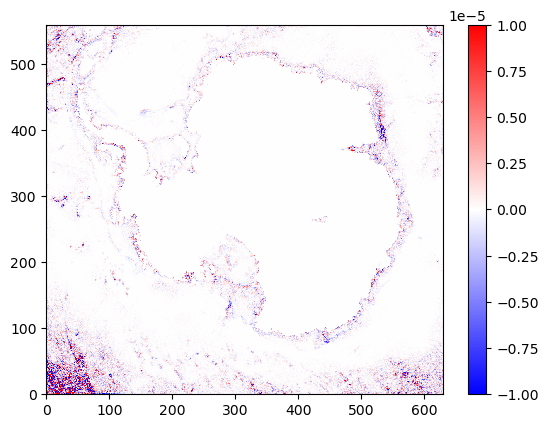

In [10]:
plt.pcolormesh(temp_vadv.isel(s_rho=0).mean('ocean_time'), cmap='bwr', vmin=-0.00001, vmax=0.00001)
plt.colorbar()

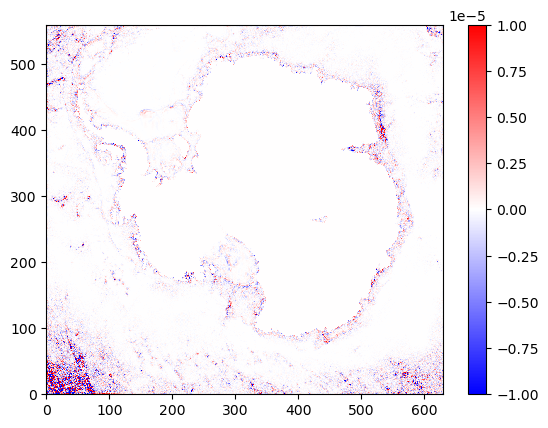

In [11]:
plt.pcolormesh(temp_hadv.isel(s_rho=0).mean('ocean_time'), cmap='bwr', vmin=-0.00001, vmax=0.00001)
plt.colorbar()

CancelledError: ('mean_agg-aggregate-e3aa1a9d10a9a06e86640209d4bf15b3', 0, 0, 0)

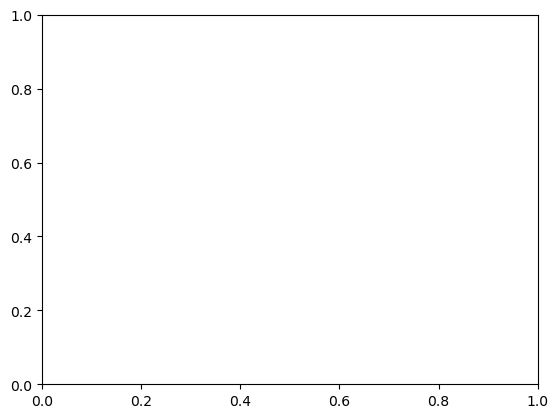

In [12]:
plt.pcolormesh(temp_vadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
plt.colorbar()

In [ ]:
plt.pcolor(temp_hadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.001, vmax=0.001)
plt.colorbar()

In [ ]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'


In [ ]:
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)


In [ ]:
ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_11yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False)
omega = ds.variables["omega"]
ds.close()

In [ ]:
omega

In [ ]:
plt.pcolormesh(omega.isel(s_w=0, ocean_time=40), cmap='bwr')#, vmin=-0.0001, vmax=0.0001)
plt.colorbar()

In [ ]:
plt.pcolormesh(omega.isel(s_w=-1, ocean_time=40), cmap='bwr')#, vmin=-0.0001, vmax=0.0001)
plt.colorbar()

Ok, double-checking Omega, they are indeed zero at the surface and bottom layers. So why the temp_vadv doesn't vanish when vertically integrated over the whole column beneath the ice shelves???

In [ ]:
%%time

ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_11yr_diag_daily/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] ##+273.15 (changing to Kelvin didn't change any results)
time_snap = ds.variables["ocean_time"]
ds.close()


In [ ]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/scratch/gi0/fbd581/waom10extend_testcode/output_01-10yr/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=1, two=0) ##+273.15 (changing to Kelvin didn't change any results) # 5-days mean
time_ini = ds.variables["ocean_time"].isel(ocean_time=1)
ds.close()

    
tlen = len(temp[:,0,0,0])

In [ ]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
# dt = 5*86400 # 5-days in seconds
dt = 1*86400 # 1day
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

In [ ]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

In [ ]:
plt.pcolormesh(h+zice, vmin=0, vmax=0.5)
plt.colorbar()

In [ ]:
plt.pcolormesh(contour_masked_above)#, vmin=0, vmax=1)
plt.colorbar()

In [ ]:
# Define conditions to mask out (1) off the shelf, (2) land (see plots above)
condition1 = contour_masked_above == -1000
condition2 = (zice+h) <= 1

# Combine conditions with logical OR
combined_condition = condition1 | condition2


In [ ]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure*1
# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux_masked = ma.masked_where(combined_condition, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.
    shflux_area = shflux_masked*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    #del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vint_masked =  ma.masked_where(combined_condition, temp_rate_vint)
    temp_rate_vol[mm,:] = temp_rate_vint_masked*area
    
    #del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(temp_rate_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
temp_hadv.load()
temp_vadv.load()
temp_hdiff.load()
temp_vdiff.load()
temp_sdiff.load()

In [ ]:
# define sum of all RHS:
RHS_budget = temp_hadv + temp_vadv + temp_hdiff + temp_vdiff
RHS_budget_masked = ma.masked_where(combined_condition, RHS_budget.sum('s_rho').isel(ocean_time=0))

plt.pcolormesh(RHS_budget_masked)
plt.colorbar()

In [ ]:
%%time
# integral with all RHS terms (as suggested by Wilkin)
RHS_budget_int = np.empty((tlen))
RHS_budget_vol = np.empty(np.squeeze(RHS_budget[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    RHS_budget_dz = RHS_budget[mm,:]*dz[mm,:]
    RHS_budget_vint = np.nansum(RHS_budget_dz, axis=0)
    RHS_budget_vint_masked =  ma.masked_where(combined_condition, RHS_budget_vint)
    RHS_budget_vol[mm,:] = RHS_budget_vint_masked*area
    RHS_budget_int[mm] = np.nansum(np.nansum(RHS_budget_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 3. heat tendency due to horizontal diffusion:
temp_hdiff_int = np.empty((tlen))
temp_hdiff_vol = np.empty(np.squeeze(temp_hdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hdiff_dz = temp_hdiff[mm,:]*dz[mm,:]
    temp_hdiff_vint = np.nansum(temp_hdiff_dz, axis=0)
    temp_hdiff_vint_masked =  ma.masked_where(combined_condition, temp_hdiff_vint)
    temp_hdiff_vol[mm,:] = temp_hdiff_vint_masked*area
    temp_hdiff_int[mm] = np.nansum(np.nansum(temp_hdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 4. heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(combined_condition, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
    temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 5. heat tendency due to vertical advection:
temp_vadv_int = np.empty((tlen))
temp_vadv_vol = np.empty(np.squeeze(temp_vadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vadv_dz = temp_vadv[mm,:]*dz[mm,:]
    temp_vadv_vint = np.nansum(temp_vadv_dz, axis=0)
    temp_vadv_vint_masked =  ma.masked_where(combined_condition, temp_vadv_vint)
    temp_vadv_vol[mm,:] = temp_vadv_vint_masked*area
    temp_vadv_int[mm] = np.nansum(np.nansum(temp_vadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 6. heat tendency due to vertical diffusion (should be equal to the sfc heat flux)
temp_vdiff_int = np.empty((tlen))
temp_vdiff_vol = np.empty(np.squeeze(temp_vdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vdiff_dz = temp_vdiff[mm,:]*dz[mm,:]
    temp_vdiff_vint = np.nansum(temp_vdiff_dz, axis=0)
    temp_vdiff_vint_masked =  ma.masked_where(combined_condition, temp_vdiff_vint) # I think I can remove the first masking, no need to repeat it.
    temp_vdiff_vol[mm,:] = temp_vdiff_vint_masked*area
    temp_vdiff_int[mm] = np.nansum(np.nansum(temp_vdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 7. heat tendency due to rotated diffusion (should be equal to the sfc heat flux)
temp_sdiff_int = np.empty((tlen))
temp_sdiff_vol = np.empty(np.squeeze(temp_sdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_sdiff_dz = temp_sdiff[mm,:]*dz[mm,:]
    temp_sdiff_vint = np.nansum(temp_sdiff_dz, axis=0)
    temp_sdiff_vint_masked =  ma.masked_where(combined_condition, temp_sdiff_vint) # I think I can remove the first masking, no need to repeat it.
    temp_sdiff_vol[mm,:] = temp_sdiff_vint_masked*area
    temp_sdiff_int[mm] = np.nansum(np.nansum(temp_sdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
temp_hdiff_vol.shape

In [ ]:
# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

In [ ]:
print(temp_Rate.shape, dz.shape)

In [ ]:
print(temp_rate_vol.shape, temp_rate_int.shape)
print(np.mean(temp_rate_int))#/area_sum)

In [ ]:
mm=35
# plt.pcolormesh(ma.masked_where(contour_masked_above == -1000,temp_rate_vol[mm,:]), vmin=-2e4, vmax=2e4, cmap='coolwarm')
plt.pcolormesh(np.nanmean(temp_rate_vol, axis=0), vmin=-1e3, vmax=1e3, cmap='coolwarm')
plt.colorbar()

In [ ]:
plt.pcolormesh(ma.masked_where(contour_masked_above == -1000, np.nanmean(shflux,axis=0)*(area/(Cp*rho0))), vmin=-2e3, vmax=2e3, cmap='coolwarm')
plt.colorbar()

shflux_area.shape

In [ ]:
plt.pcolormesh(np.nanmean(temp_hadv_vol,axis=0)+np.nanmean(temp_vadv_vol,axis=0), vmin=-1e4, vmax=1e4, cmap='coolwarm')
plt.colorbar()
plt.title('hadv + vadv')

In [ ]:
plt.pcolormesh(np.nanmean(temp_hadv_vol,axis=0), vmin=-1e4, vmax=1e4, cmap='coolwarm')
plt.colorbar()
plt.title('vadv')

In [ ]:
     
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,5))

ax[0].title.set_text('WAOM10 \n Heat content tendencies')
# aa=ax[0].pcolormesh(np.nanmean(temp_rate_vol[1:-1], axis=0)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# divide by 2.5 to be comparable to 4km maps (normalized by area instead?)
# aa=ax[0].pcolormesh(np.divide(np.nanmean(temp_rate_vol[1:-1], axis=0),2.5)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# divided by area
aa=ax[0].pcolormesh(np.divide(np.nanmean(temp_rate_vol[1:-1,:], axis=0),area_sum), vmin=-1e-9, vmax=1e-9, cmap='coolwarm')
# plt.colorbar(aa)

#  define 5-daily masked shflux:
shflux_masked = np.empty(shflux.shape)
for mm in np.arange(0,tlen):
    shflux_masked[mm,:,:] = ma.masked_where(contour_masked_above == -1000, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.


ax[1].title.set_text('WAOM10 \n Surface heat flux')
# bb=ax[1].pcolormesh(np.nanmean(shflux[1:-1], axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
bb=ax[1].pcolormesh(np.divide(np.nanmean(shflux_masked[1:-1,:], axis=0),area_sum), vmin=-1e-9, vmax=1e-9, cmap='coolwarm') ##vmin=-100, vmax=100, cmap='coolwarm')

cax2 = plt.axes([0.92, 0.11, 0.01, 0.77])
cb = plt.colorbar(bb, cax=cax2, orientation='vertical')
cb.ax.set_ylabel('W.m$^{-2}$', fontsize=12)

# including comparison oldXnew estitemas below:
# cc=ax[1,0].pcolormesh(np.nanmean(temp_rate2_vol, axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
# dd=ax[1,1].pcolormesh(np.nanmean(shflux2, axis=0), vmin=-100, vmax=100, cmap='coolwarm')

# # diff maps:
# ee=ax[2,0].pcolormesh((np.nanmean(temp_rate_vol, axis=0))-(np.nanmean(temp_rate2_vol, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')
# ff=ax[2,1].pcolormesh((np.nanmean(shflux, axis=0))-(np.nanmean(shflux2, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')




In [ ]:
# OHB integrated
print('OHC tendency annual avg (TW): ',np.nanmean(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nanmean(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nanmean(temp_rate_int)-np.nanmean(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nanmean(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nanmean(temp_vdiff_int)*1e-12)
print('Isop. diffusion (TW): ',np.nanmean(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nanmean(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nanmean(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nanmean(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nanmean(RHS_budget_int)*1e-12)

In [ ]:
# OHB integrated, sum over 1year:
print('OHC tendency annual avg (TW): ',np.nansum(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nansum(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nansum(temp_rate_int)-np.nansum(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nansum(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nansum(temp_vdiff_int)*1e-12)
print('Isop. diffusion (TW): ',np.nansum(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nansum(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nansum(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nansum(RHS_budget_int)*1e-12)

In [ ]:

months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,temp_hdiff_int, label='Horz. diffusion of heat', color='lightgreen')
plt.plot(months,temp_vdiff_int, label='Vert. diffusion of heat', color='darkgreen')
plt.plot(months,temp_hdiff_int+temp_vdiff_int+temp_vadv_int,'--', label='Total diffusion + vadv', color='darkgreen')
plt.plot(months,temp_hadv_int, label='Horz. advection of heat',color='darkred')
plt.plot(months,temp_vadv_int, label='Vert. advection of heat',color='darkblue')
plt.plot(months,RHS_budget_int - shflux_int, label='RHS - SHFLX',color='y')

plt.plot(months,shflux_int*0,'--k')
plt.plot(months,temp_rate_int - shflux_int, ':r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=1, color='red')
# plt.plot(months,all_rhs, '--m', label='all RHS',linewidth=1)
# plt.ylim([-2e14,2e14])
# print annual avg values:
# plt.text(10.2,-.5e14,str(np.round(np.mean(shflux_int)*1e-12,decimals=4)) + 'TW', color='royalblue')
# plt.text(10.2,1.65e14,str(np.round(np.mean(temp_rate_int)*1e-12,decimals=4)) + 'TW', color='darkorange')
# plt.text(9.2,1.1e14,str(np.round(np.mean(temp_rate_int - shflux_int)*1e-12,decimals=4)) + 'TW', color='red')
# # plt.text(10.2,1.35e14,str(np.round(np.mean(temp_hdiff_int)*1e-12,decimals=4)) + 'TW', color='green')
# plt.text(10.9,-.35e14,str(np.round(np.mean(temp_hadv_int)*1e-12,decimals=4)) + 'TW', color='darkred')
# plt.text(9,.8e14,str(np.round(np.mean(temp_vadv_int)*1e-12,decimals=4)) + 'TW', color='darkblue')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_newcode_OHB_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,RHS_budget_int - shflux_int,'--m', label='RHS - SHFLX')
plt.plot(months,temp_rate_int - shflux_int, '-r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=0.5, color='red')
# plt.plot(months,temp_hadv_int, label='Horz. advection of heat',color='darkred')

plt.plot(months,shflux_int*0,'--k')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_newcode_OHB-closure_test_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
%%time

# temp_rate_int, shflux_int

months=np.arange(0,365)*(1/30.41667)

# save to netcdf file:
coordinatesC=dict(ocean_time=months)

temp_rate_int_xr = xr.DataArray(temp_rate_int, coords = coordinatesC, dims = ['ocean_time'])
shflux_int_xr = xr.DataArray(shflux_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hdiff_int_xr = xr.DataArray(temp_hdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vdiff_int_xr = xr.DataArray(temp_vdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vadv_int_xr = xr.DataArray(temp_vadv_int, coords = coordinatesC, dims = ['ocean_time'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_rate_int_xr.to_netcdf(files_path + 'WAOM10_newcode_OHB_1500m_temp_rate_vint_daily', mode='w', format="NETCDF4")
shflux_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr11_OHB_1500m_shflux_vint_daily', mode='w', format="NETCDF4")
temp_hdiff_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr11_OHB_1500m_temp_hdiff_vint_daily', mode='w', format="NETCDF4")
temp_vdiff_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr11_OHB_1500m_temp_vdiff_vint_daily', mode='w', format="NETCDF4")
temp_hadv_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr11_OHB_1500m_temp_hadv_vint_daily', mode='w', format="NETCDF4")
temp_vadv_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr11_OHB_1500m_temp_vadv_vint_daily', mode='w', format="NETCDF4")

In [ ]:
shflux_int.shape

In [ ]:
print(np.nanmean(temp_rate_int - shflux_int)*1e-12)
print(np.nanmean(RHS_budget_int)*1e-12)